# UCOOT Tutorial

In this tutorial, we will examine how to use Co-Optimal Transport (COOT) and Unbalanced Co-Optimal Transport (UCOOT) to align a CITEseq dataset, which contains co-assayed gene expression and antibody data on 1000 human blood cells (subsetted from a dataset of 7985 human/mouse blood cells). We will split this dataset into gene expression data and antibody data in hopes that UCOOT will be able to recover which samples match in the full dataset (same goal as in UGW).

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you are unsure how to initialize a Solver object, view our setup tutorial to get a sense for how to trade speed and accuracy using its constructor parameters.

If the notation and problem formulation seem confusing, try viewing our document on the theory of optimal transport to get more comfortable first.

If you want a more gradual intro into this tool, start with our UGW tutorial.

If you are already comfortable with UCOOT, try moving on to our fused formulation tutorial or our AGW tutorial.
```

### Data Download

We provide preprocessed data on the 1000 cells we will be working with. However, if you would like to do the preprocessing yourself (for example, following the steps in Tran et al.) and do not already have the PBMC_ADT and PBMC_RNA files downloaded from the CITE-seq dataset, run the following commands in the terminal in the root directory of this tutorial repository:

<center> sh ./download_scripts/CITEseq_download.sh </center>

If you have not modified our original directory structure for the data, these files will be dropped into the same folder as the preprocessed datasets.

### Preprocessing

We will start with some mild preprocessing, such as loading the preprocessed datasets into variables local to this notebook. We begin by setting up pytorch. Use this as is, unless you would like to try a different device.

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


As in the UGW tutorial, we omit our exact preprocessing steps and move directly towards alignment. If you are curious to do your own preprocessing, we recommend doing it here, as well as trying to keep your final variable names consistent with ours.

In [2]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, calc_domainAveraged_FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]


```{note}
As in the UGW tutorial, we examine a subset of 10 of the 25 gene-antibody pairs.
```

In [3]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt_full_annotated = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna_full_annotated = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt_full_annotated.index, adt_full_annotated.columns = samp_labels, adt_feat_labels
rna_full_annotated.index, rna_full_annotated.columns = samp_labels, rna_feat_labels

# gather full data in numpy
adt_full = adt_full_annotated.to_numpy()
rna_full = rna_full_annotated.to_numpy()

# subset annotated data
adt_annotated = adt_full_annotated.iloc[:,0:10]
rna_annotated = rna_full_annotated.iloc[:,0:10]

# gather subset in numpy
adt = adt_annotated.to_numpy()
rna = rna_annotated.to_numpy()


Now that we have our two matrices ready, we can remind ourselves what the original domains looked like in the UGW tutorial.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


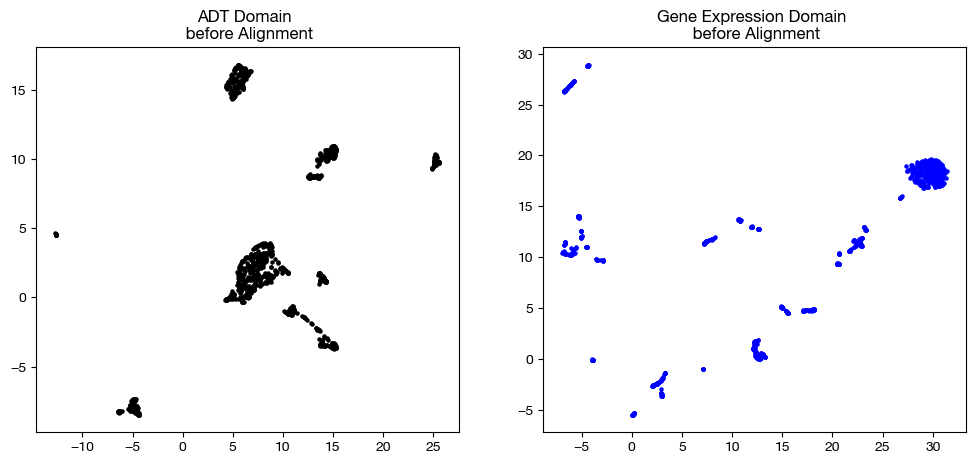

In [21]:
um = umap.UMAP(random_state=0)

original_adt_um=um.fit_transform(adt)
original_rna_um=um.fit_transform(rna)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

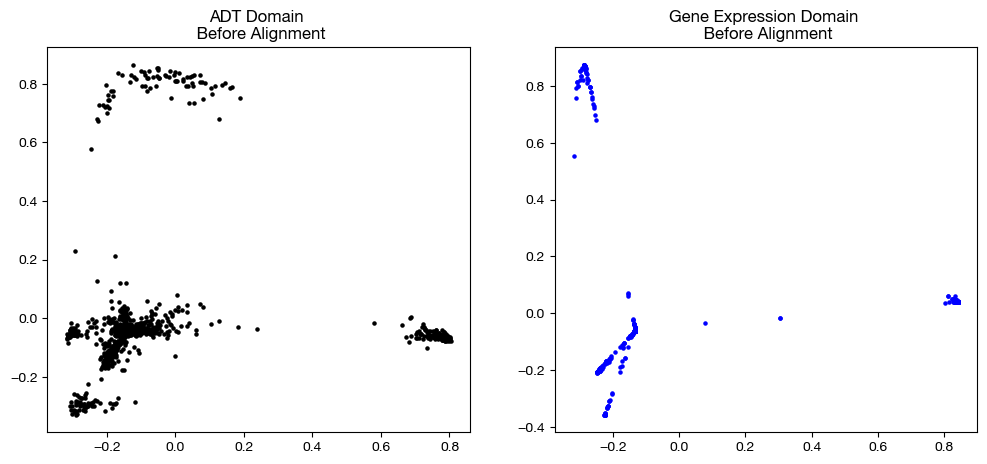

In [22]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

original_adt_pca=pca.fit_transform(adt)
original_rna_pca=pca.fit_transform(rna)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Default UCOOT

With the data loaded and preprocessed, we can begin by instantiating a Solver object.

In [4]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3)

From here, we can begin solving our UCOOT problem. Note that UCOOT aligns both samples and features between two datasets that share an underlying manifold. In order to have the flexibility to do this, UCOOT has a number of hyperparameters, which we will examine over the course of this tutorial. 

Before we start looking at results, let's remember what exactly UCOOT seeks to do. Unlike UGW, UCOOT simultaneously aligns samples and features and does not consider pairwise distances directly. Instead, for all sample-feature pairs ($i, j$) in $X$ and pairs ($k$, $l$) in $y$ (these pairs identify a particular entry in one of these matrices of data), UCOOT seeks to minimize the following transport cost:

$L(X_{ij}, y_{kl}) \cdot \pi_{s_{ik}} \cdot \pi_{f_{jl}}$

Where $L$ is some function that defines the cost of matching $X_{ij}$ to $y_{kl}$, $\pi_s$ is the sample coupling matrix, and $\pi_f$ is the feature coupling matrix. In our case, $L$ will be euclidean distance. Intuitively, this cost function indicates that UCOOT will encourage matching samples $i$ and $k$ that have similar values for features $k$, $l$ that are similar with respect to the samples of their respective domains. As you might be able to tell, this encouragment leads to some circular logic; this dependency of feature coupling on sample coupling allows the matrices to converge to minimize the above cost function. In relation to UGW, UCOOT encourages matching samples that are similar relative to the features of their respective domains, rather than the other samples (as in UGW). 

Let's try using the UCOOT solver with its default parameters to see how the procedure works. In this first section, we will also go over how to score and project data using solved UCOOT coupling matrices.

In [24]:
# set verbose=True to get a breakdown of the cost progression during optimization
# set log=True to get extra return values, log_cost and log_ent_cost, which display the cost progression
(pi_samp, _, pi_feat), _, log_ent_cost = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), verbose=True, log=True, eps=1e-3)

BCD Iteration 1 - Loss: 0.051248, 0.052950


BCD Iteration 2 - Loss: 0.007932, 0.011220
BCD Iteration 3 - Loss: 0.007174, 0.010670
BCD Iteration 4 - Loss: 0.007149, 0.010664
BCD Iteration 5 - Loss: 0.007146, 0.010664


Notice how the solver we used returns a tuple of coupling matrices, the vectors resulting from the Sinkhorn algorithm used to generate these coupling matrices, and two logs of the cost progression (same as UGW). The first matrix in the tuple returned is the coupling matrix for samples, while the second matrix returned is the coupling matrix for features. From here, we use the first matrix to project the gene expression data samples into the domain of the ADT samples:

In [25]:
aligned_rna = get_barycentre(torch.from_numpy(adt).to(device), pi_samp)
aligned_rna.numpy().shape

(1000, 10)

```{warning}
In this projection step, be careful how you use X and y. Whichever matrix you entered first (call this X) in the original alignment will have its samples on the vertical axis of pi_samp, meaning that calling get_barycentre(X, pi_samp) will project the other matrix, y, into the feature-space of X. 
```

Note that these coupling matrices have value in their own right – we can use them to understand the relationships between samples or features based on how much mass is transported from a sample/feature in one domain to a sample/feature in the other. Considering we tend to get a good picture of the sample alignment after projection in our UMAPs/PCAs, we focus on the feature coupling matrices in these heatmaps.

<Axes: >

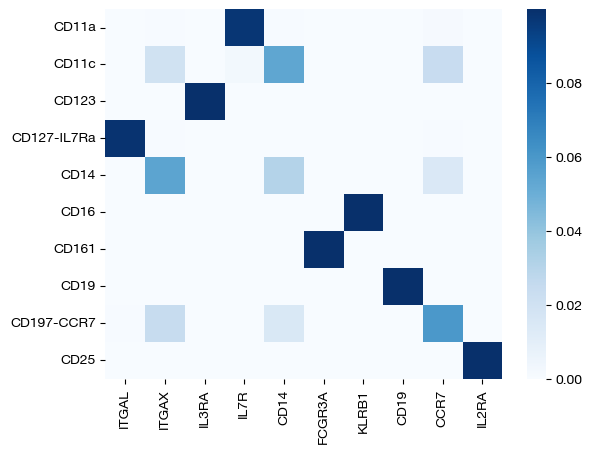

In [26]:
import seaborn as sns

sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), cmap='Blues')

With our newly aligned data, which contains estimated ADT data on the samples from the gene expression data, we can do a few things. First, we can score how good the alignment is using the FOSCTTM metric we discussed in the UGW tutorial.

Average FOSCTTM score for this alignment with X onto Y is: 0.31195995995995995


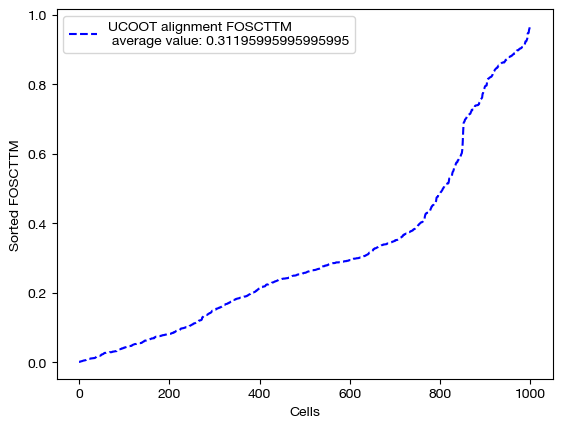

In [27]:
fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
print("Average FOSCTTM score for this alignment with X onto Y is:", np.mean(fracs))
legend_label="UCOOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

The closer the FOSCTTM is to 0, and the more convex this curve above, the better the alignment is. Note that a metric like FOSCTTM cannot be applied to data without a known, underlying 1-1 mapping. For these cases, we do use something call label transfer accuracy, which we will examine in the future.

From here, we can visualize the data, again with UMAP and PCA:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


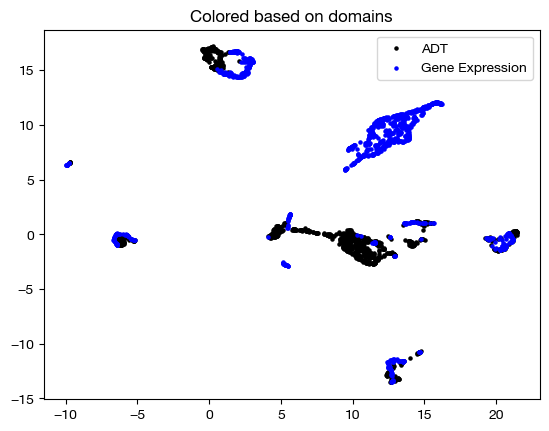

In [28]:
joint_um=um.fit_transform(np.concatenate((adt, aligned_rna.numpy()), axis=0))

adt_um=joint_um[0:1000,]
aligned_rna_um=joint_um[1000:,]

plt.scatter(adt_um[:,0], adt_um[:,1], c="k", s=5, label="ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

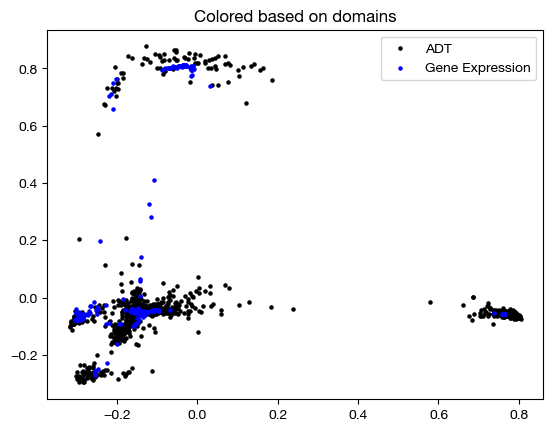

In [29]:
pca=PCA(n_components=2)
joint_pca=pca.fit_transform(np.concatenate((adt, aligned_rna.numpy()), axis=0))
adt_pca=joint_pca[0:1000,]
aligned_rna_pca=joint_pca[1000:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(adt_pca[:,0], adt_pca[:,1], c="k", s=5, label="ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

### Entropic Regularization

With this example under our belt, let's try playing around with some of the different modes and hyperparameters.

First, we will experiment with $\epsilon$. The $\epsilon$ parameter changes the weight of the entropy term, which we add to the transport cost term discussed above when minimizing cost and optimizing our two coupling matrices. The more weight the entropy term has, the more entropy we will see in the final convergence of the UCOOT algorithm. This means that the resulting coupling matrices for both samples and features will be more dense (further away from 1-1 alignment). However, a higher value of $\epsilon$ makes the UCOOT algorithm converge faster. As a result, $\epsilon$ serves as a tradeoff between speed and precision, at least to some extent. Let's compare three values: a reasonable $\epsilon$ value for this data, a large $\epsilon$ value, and a small $\epsilon$ value. Note that this is performed with independent entropic regularization (we will go over joint later).

In [30]:
(pi_samp_small, _, pi_feat_small), _, log_ent_cost = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-4, log=True)

print(len(log_ent_cost))

(pi_samp_med, _, pi_feat_med), _, log_ent_cost = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-2, log=True)

print(len(log_ent_cost))

(pi_samp_lg, _, pi_feat_lg), _, log_ent_cost = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1, log=True)

print(len(log_ent_cost))

BCD Iteration 1 - Loss: 0.061881, 0.064542


BCD Iteration 2 - Loss: 0.036687, 0.046061
BCD Iteration 3 - Loss: 0.028733, 0.042182
BCD Iteration 4 - Loss: 0.021220, 0.038847
BCD Iteration 5 - Loss: 0.012737, 0.034812
BCD Iteration 6 - Loss: 0.012277, 0.034751
BCD Iteration 7 - Loss: 0.012133, 0.034734
BCD Iteration 8 - Loss: 0.011947, 0.034716
BCD Iteration 9 - Loss: 0.011746, 0.034699
BCD Iteration 10 - Loss: 0.011587, 0.034690
BCD Iteration 11 - Loss: 0.011498, 0.034687
BCD Iteration 12 - Loss: 0.011457, 0.034686
12
BCD Iteration 1 - Loss: 0.067676, 0.067721
BCD Iteration 2 - Loss: 0.067676, 0.067720
2
BCD Iteration 1 - Loss: 0.067760, 0.067759
BCD Iteration 2 - Loss: 0.067760, 0.067758
BCD Iteration 3 - Loss: 0.067760, 0.067758
3


Note how, in the above alignments, the length of the cost log decreases from a very small $\epsilon$ to higher $\epsilon$ – this means that the solver is converging faster. Now, let's align the data and examine the FOSCTTM scores for each alignment:

In [31]:
aligned_rna_sm = get_barycentre(torch.from_numpy(rna).to(device), pi_samp_small)
aligned_rna_med = get_barycentre(torch.from_numpy(rna).to(device), pi_samp_med)
aligned_rna_lg = get_barycentre(torch.from_numpy(rna).to(device), pi_samp_lg)

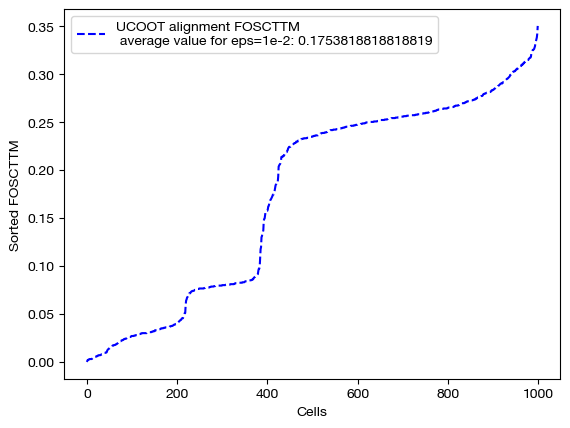

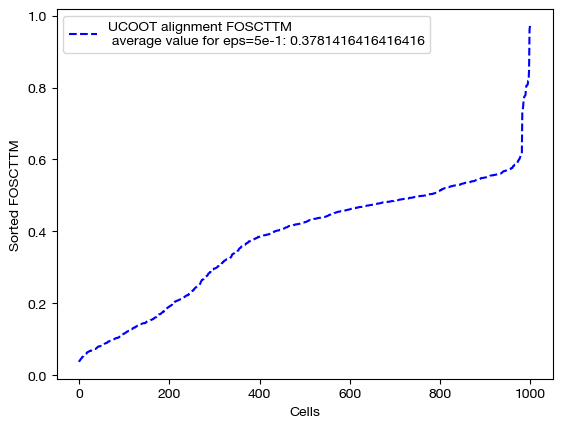

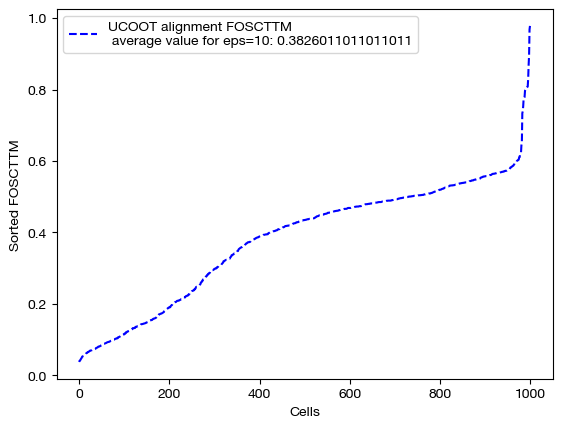

In [32]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-2'), (aligned_rna_med, 'eps=5e-1'), (aligned_rna_lg, 'eps=10')]:
    fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
    legend_label="UCOOT alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

As seen above, decreasing $\epsilon$ is not a surefire way to improve alignment quality. Try experimenting with a wide range of $\epsilon$ to find the best $\epsilon$ for your data:

In [33]:
# an example of epsilon search
pi_samp_dt = {}
pi_feat_dt = {}
# for val in np.logspace(start=-6, stop=-1, num=10):
    # pi_samp_dt[val], _, pi_feat_dt[val] = scot.coot(torch.from_numpy(X).to(device), torch.from_numpy(y).to(device), eps=val)

To wrap up our investigation of $\epsilon$, let's visualize the results from our three different $\epsilon$ values. We will begin by looking at the coupling matrices from our alignments:

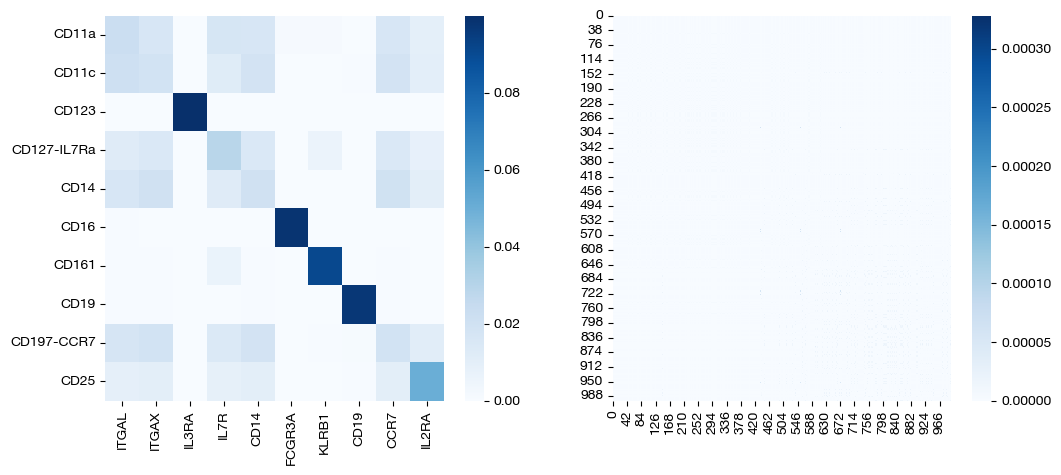

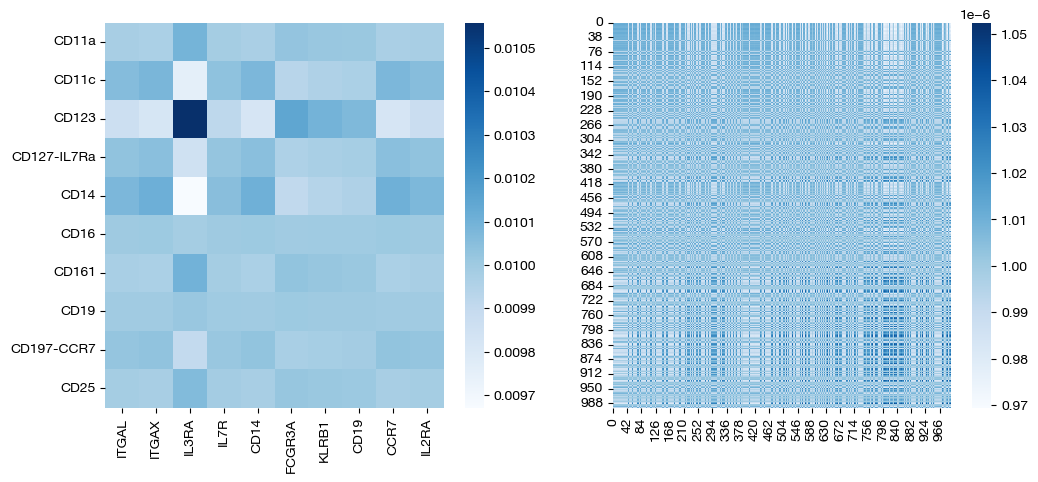

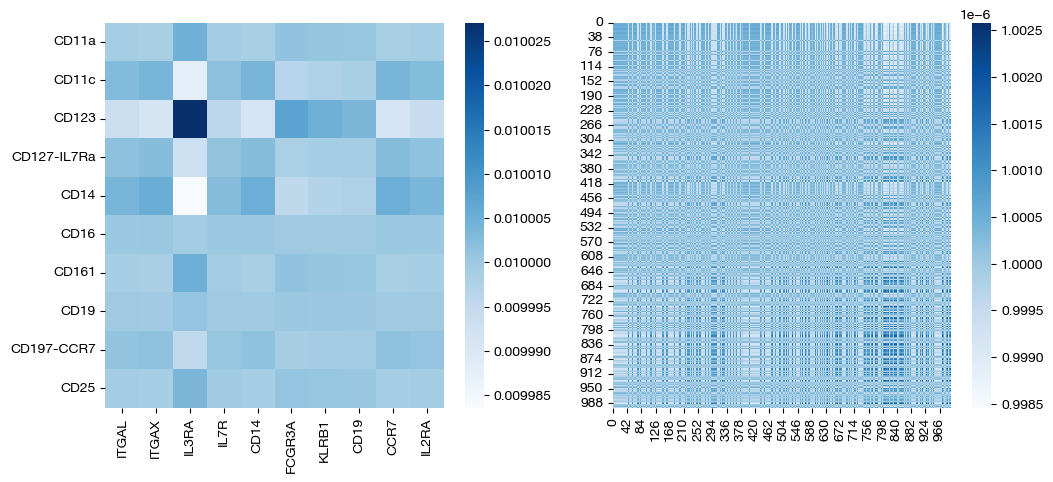

In [34]:
for pi_feat, pi_samp, size in [(pi_feat_small, pi_samp_small, 'eps=1e-2'), (pi_feat_med, pi_samp_med, 'eps=5e-1'), (pi_feat_lg, pi_samp_lg, 'eps=10')]:
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp, ax=ax2, cmap='Blues')
    plt.show()

Note that the first two coupling matrices are quite sparse, but for the largest value of $\epsilon$, the coupling matrices are very dense. This result fits with what we expected when we first introduced $\epsilon$ earlier. Now, we can look at the UMAPs to get a sense for what this means with regards to alignment:

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


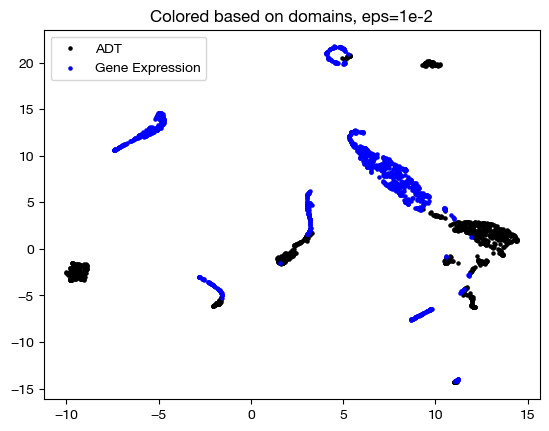

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


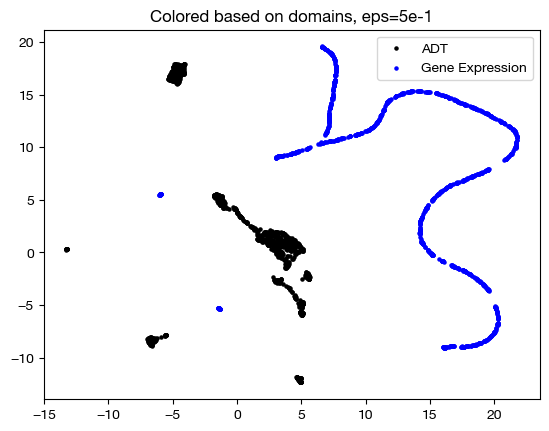

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


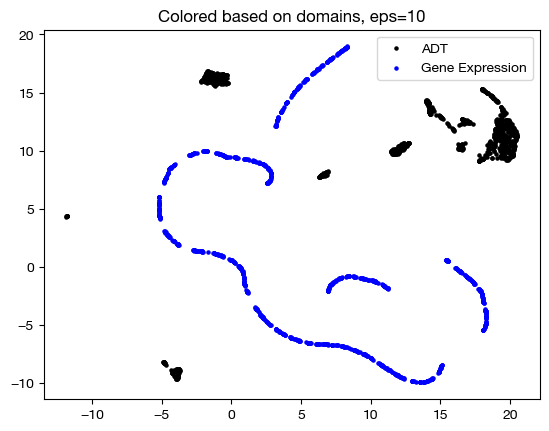

In [35]:
for aligned_rna, size in [(aligned_rna_sm, 'eps=1e-2'), (aligned_rna_med, 'eps=5e-1'), (aligned_rna_lg, 'eps=10')]:    

    joint_um=um.fit_transform(np.concatenate((adt, aligned_rna.numpy()), axis=0))

    adt_um=joint_um[0:1000,]
    aligned_rna_um=joint_um[1000:,]

    plt.scatter(adt_um[:,0], adt_um[:,1], c="k", s=5, label="ADT")
    plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, label="Gene Expression")
    plt.legend()
    plt.title("Colored based on domains, {0}".format(size))
    plt.show()

Notice how, with the very small value for $\epsilon$, we get something closer to a 1-1 mapping in the UMAP; however, it seems like it may be "overfit" with the way the data groups into very small, separated clusters. On the other hand, notice that with the large value for $\epsilon$, we get no such 1-1 alignment. In fact, if we look at its PCA:

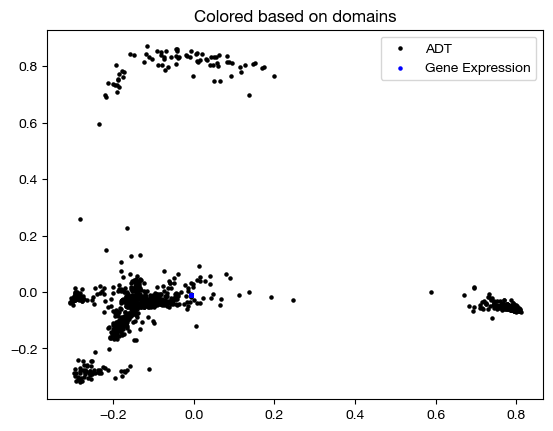

In [36]:
pca=PCA(n_components=2)
joint_pca=pca.fit_transform(np.concatenate((adt, aligned_rna_lg.numpy()), axis=0))
adt_pca=joint_pca[0:1000,]
aligned_rna_pca=joint_pca[1000:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(adt_pca[:,0], adt_pca[:,1], c="k", s=5, label="ADT")
plt.scatter(aligned_rna_pca[:,0], aligned_rna_pca[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

We can see that the gene expression data all gets projected near the origin on the PCA graph of the original ADT data – this indicates that the projection is getting closer to a weighted average of all samples in the original ADT domain, applied to each sample in the gene expression domain (low variance in aligned values). This result is exactly what we would expect, given a very dense sample coupling matrix.

Our default value for $\epsilon$ is 1e-4, which we believe should be somewhat close to the correct tradeoff for many datasets.

From here, we will quickly examine joint versus independent entropic regularization. In the joint case, we entropically regularize by adding a term to the cost function that measures the joint entropy of the sample AND feature coupling matrices. However, in the independent case (default, which we have been implicitly using so far), we add two terms to the cost function; one that measures the entropy of the sample coupling matrix, and one that measures the entropy of the feature coupling matrix. If you are trying to get a more sparse coupling matrix of either the features or the samples in the hopes of getting something closer to a map, you might use independent entropic regularization and lower the $\epsilon$ value for the relevant entropy term.

To specify the type of entropic regularization you are using, pass in 'joint' or 'independent' to the entropic_mode parameter of the fucoot_solver function. If you use joint regularization, only the first term of your $\epsilon$ tuple will be used in solving. Let's make one comparison of joint vs. independent entropic regulariztion:

In [50]:
pi_samp_ind, _, pi_feat_ind = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-3, entropic_mode="independent")

pi_samp_jnt, _, pi_feat_jnt = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-3, entropic_mode="joint")

BCD Iteration 1 - Loss: 0.047160, 0.047474
BCD Iteration 2 - Loss: 0.008839, 0.009266
BCD Iteration 3 - Loss: 0.008696, 0.009130
BCD Iteration 4 - Loss: 0.008705, 0.009140
BCD Iteration 5 - Loss: 0.008687, 0.009121
BCD Iteration 6 - Loss: 0.008669, 0.009103
BCD Iteration 7 - Loss: 0.008651, 0.009085
BCD Iteration 8 - Loss: 0.008648, 0.009083
BCD Iteration 9 - Loss: 0.008648, 0.009083
BCD Iteration 1 - Loss: 0.047160, 0.047474
BCD Iteration 2 - Loss: 0.008839, 0.009266
BCD Iteration 3 - Loss: 0.008696, 0.009130
BCD Iteration 4 - Loss: 0.008705, 0.009140
BCD Iteration 5 - Loss: 0.008687, 0.009121
BCD Iteration 6 - Loss: 0.008669, 0.009103
BCD Iteration 7 - Loss: 0.008651, 0.009085
BCD Iteration 8 - Loss: 0.008648, 0.009083
BCD Iteration 9 - Loss: 0.008648, 0.009083


We can look at the resulting coupling matrices:

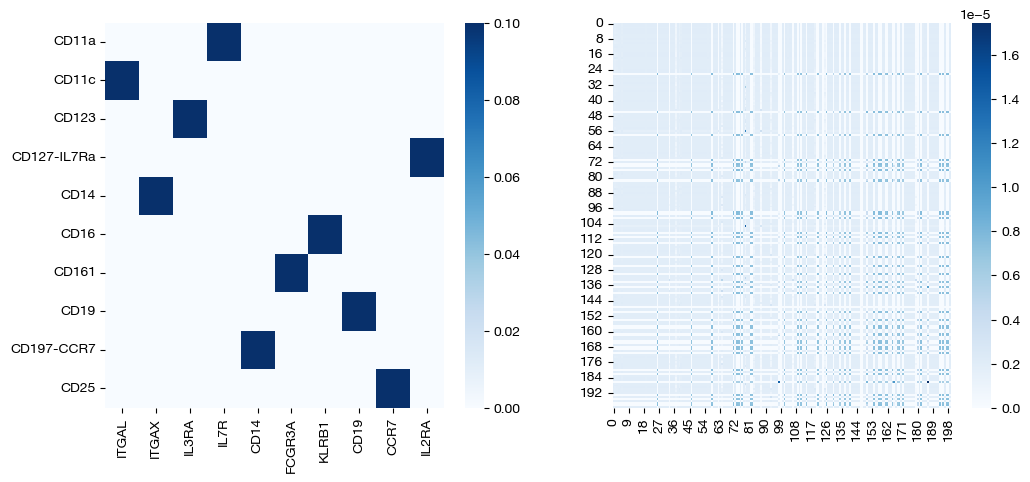

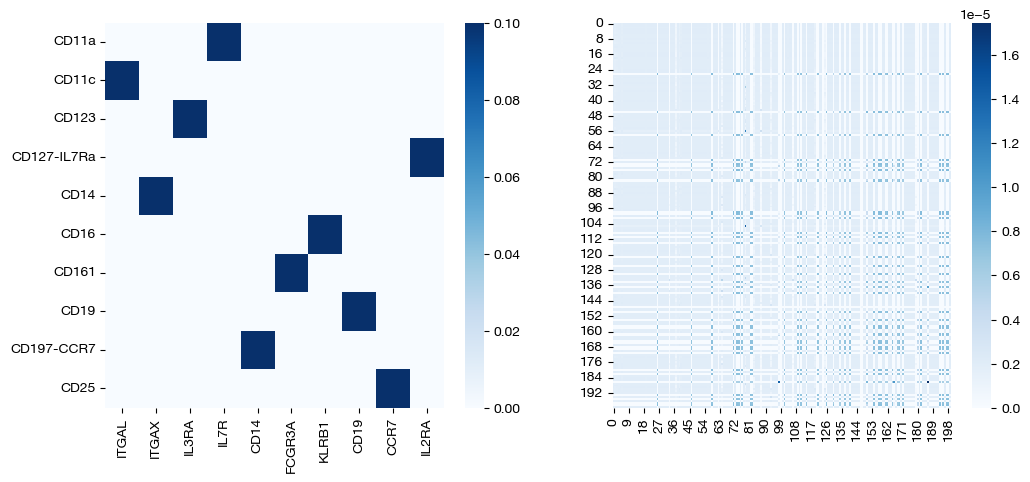

In [52]:
for pi_feat, pi_samp, mode in [(pi_feat_ind, pi_samp_ind, 'independent'), (pi_feat_jnt, pi_samp_jnt, 'joint')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp[0:100,0:100], cmap='Blues')
    plt.show()

Note that these are the same, considering that we didn't let the $\epsilon$ values differ in the independent case. Let's try doing so, and comparing again:

In [7]:
pi_samp_ind, _, pi_feat_ind = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=(1e-3, 10), entropic_mode="independent")

pi_samp_jnt, _, pi_feat_jnt = scot.coot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-3, entropic_mode="joint")

BCD Iteration 1 - Loss: 0.067760, 0.067759
BCD Iteration 2 - Loss: 0.067760, 0.067758
BCD Iteration 3 - Loss: 0.067760, 0.067758
hi
hi


hi
BCD Iteration 1 - Loss: 0.051248, 0.052950
hi
hi
hi
BCD Iteration 2 - Loss: 0.007932, 0.011220
hi
hi
hi
BCD Iteration 3 - Loss: 0.007174, 0.010670
hi
hi
hi
BCD Iteration 4 - Loss: 0.007149, 0.010664
hi
hi
hi
BCD Iteration 5 - Loss: 0.007146, 0.010664


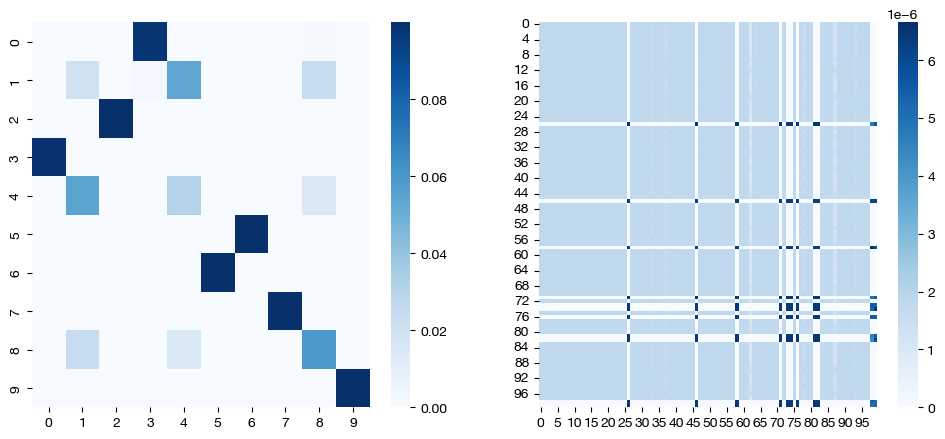

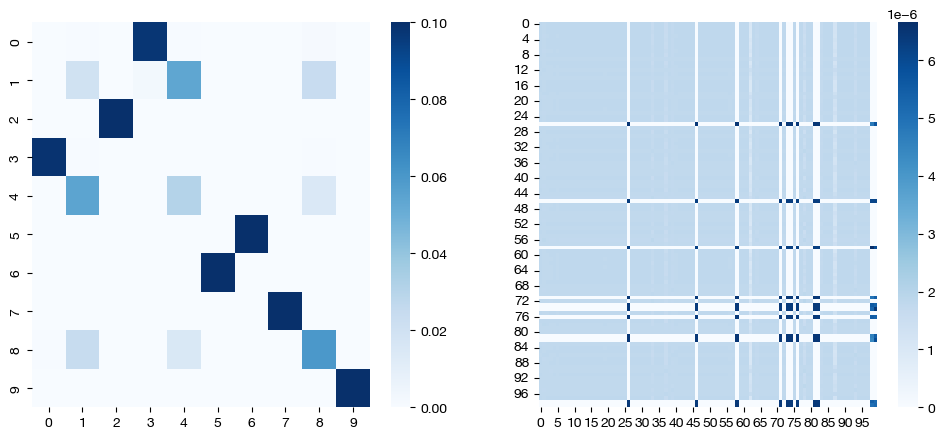

In [6]:
for pi_feat, pi_samp, mode in [(pi_feat_ind, pi_samp_ind, 'independent'), (pi_feat_jnt, pi_samp_jnt, 'joint')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pi_feat, ax=ax1, cmap='Blues')
    sns.heatmap(pi_samp[0:100,0:100], cmap='Blues')
    plt.show()

As expected, in the independent case, we get a dense feature coupling matrix (we gave $\epsilon_f = 1$, a high value). We conclude that we can leverage independent entropic regularization when we want to favor sparsity/density in one matrix over the other; however, in most cases, we recommend sticking to a singular $\epsilon$ value, with either joint or independent regularization. Tuning the extra hyperparameter for optimized performance in the independent case is unlikely to yield more meaningful results.

### Marginal Relaxation

From here, let's examine the $\rho$ hyperparameter. So far, we have been using the fcoot solver (with the exception of our last example), which does not allow for marginal relaxation via the $\rho$ hyperparameters. In the case of UCOOT (fucoot_solver), $\rho$ is a tuple of hyperparameters, one that relates to the projected domain ($\rho_y$) and one that relates to the target domain ($\rho_x$). Considering that our optimal transport problem seeks to create two matrices that define a way to transport the mass from

1. (sample coupling matrix) A probability distribution whose outcomes are samples in X to a probability distribution whose outcomes are samples in y, and

2. (feature coupling matrix) A probability distribution whose outcomes are features in X to a probability distribution whose features are samples in y,

we should constrain the marginal distributions of each coupling matrix to equal the distributions referenced in 1. and 2. respectively. In fact, in the original development of this algorithm (GW), this criterion was an additional constraint in the process of minimizing transport cost through modification of a coupling matrix. However, in UCOOT, rather than forcing this constraint upon the objective function, we add two new terms to the cost function, each of which is multiplied by their respective hyperparameters, $\rho_x$ and $\rho_y$. These terms measure the distance between the true distributions of (for example) X's samples and features, which UCOOT defaults as uniform, and the marginal distributions of the sample and feature coupling matrices. In particular, these terms utilize KL divergence to achieve such a measurement. $\rho_x$ determines the weight of the distance between the two X-related true (desired) and marginal distributions, while $\rho_y$ does the equivalent for y.

With this intuition in mind, we can see that increasing either $\rho$ parameter will lead the resulting coupling matrices to have marginals closer to the initial distributions of the samples and features of its respective dataset. Again, UCOOT's default initial distributions are both uniform. By decreasing $\rho$, however, we allow the coupling matrices to deviate further from uniform distributions, allowing either samples or features in X and y to transport more mass relative to other samples or features. This can account for disproportionate cell type representation on the sample side, as one application.

Let's try modifying $\rho$ in two different cases: one where there is no disproportionate representation of features and samples, and one where there is.

First, we have the same balanced problem from earlier; this time, we significantly relax the uniform marginal constraint (which was enforced in earlier parts of this tutorial with $\rho$=infinity, our default):

In [10]:
pi_samp, _, pi_feat = scot.ucoot(torch.from_numpy(adt).to(device), torch.from_numpy(rna).to(device), eps=1e-3, rho=(10,10))
aligned_rna = get_barycentre(torch.from_numpy(adt).to(device), pi_samp)
aligned_rna.numpy().shape

hi
hi


hi
BCD Iteration 1 - Loss: 0.066410, 0.066890
hi
hi
hi
BCD Iteration 2 - Loss: 0.066204, 0.066844
hi
hi
hi
BCD Iteration 3 - Loss: 0.066110, 0.066837
hi
hi
hi
BCD Iteration 4 - Loss: 0.066077, 0.066851
hi
hi
hi
BCD Iteration 5 - Loss: 0.066053, 0.066853
hi
hi
hi
BCD Iteration 6 - Loss: 0.066040, 0.066853


(1000, 10)

Now, we can score this case:

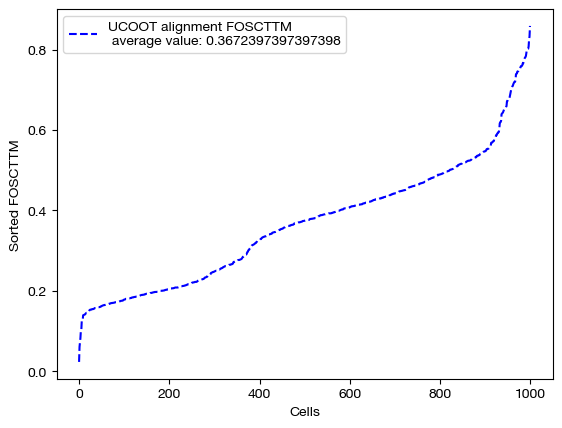

In [11]:
fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
legend_label="UCOOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

And visualize it:

In [12]:
joint_um=um.fit_transform(np.concatenate((adt, aligned_rna.numpy()), axis=0))

adt_um=joint_um[0:1000,]
aligned_rna_um=joint_um[1000:,]

plt.scatter(adt_um[:,0], adt_um[:,1], c="k", s=5, label="ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

NameError: name 'um' is not defined

Finally, we can look at the feature coupling matrix: this is where we start to see the effects of $\rho$.

<Axes: >

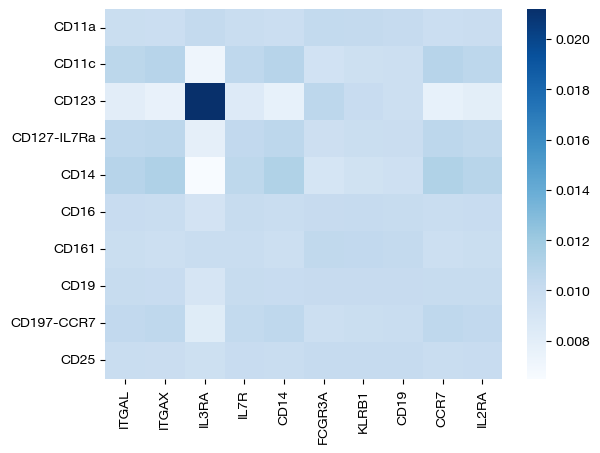

In [13]:
sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_annotated.columns), cmap='Blues')

Before, we did not see any disparity in color at this level of $\epsilon$; we saw what was essentially a 1-1 mapping, at least for features. Now, we can see that we no longer have this result. In fact, the sum of values in each row is no longer uniform, meaning some features/samples transport less mass than others. This result is exactly what we would expect when modifying $\rho$. Modifying $\rho$ can be even more useful in a disproportionate case; for example, if we add more genes into X, we want the genes associated with the 10 antibodies we have examined so far to transport more mass, in theory. Let's see if this result occurs with UCOOT; we will only lower the $\rho_y$ value in this case, as we expect the gene transport distribution to vary from uniform, while the ADT transport distribution would remain uniform.

In [18]:
pi_samp, _, pi_feat = scot.ucoot(torch.from_numpy(adt).to(device), torch.from_numpy(rna_full).to(device), eps=1e-3, rho=(float('inf'),10))

aligned_rna = get_barycentre(torch.from_numpy(adt).to(device), pi_samp)
aligned_rna.numpy().shape

hi
hi


hi
BCD Iteration 1 - Loss: 0.063426, 0.064408
hi
hi
hi
BCD Iteration 2 - Loss: 0.042120, 0.044856
hi
hi
hi
BCD Iteration 3 - Loss: 0.039114, 0.042568
hi
hi
hi
BCD Iteration 4 - Loss: 0.038568, 0.042198
hi
hi
hi
BCD Iteration 5 - Loss: 0.038528, 0.042174
hi
hi
hi
BCD Iteration 6 - Loss: 0.038542, 0.042164
hi
hi
hi
BCD Iteration 7 - Loss: 0.038538, 0.042146
hi
hi
hi
BCD Iteration 8 - Loss: 0.038551, 0.042153
hi
hi
hi
BCD Iteration 9 - Loss: 0.038549, 0.042148
hi
hi
hi
BCD Iteration 10 - Loss: 0.038549, 0.042148


(1000, 10)

We can score, visualize, and look at the feature coupling matrix now in this case:

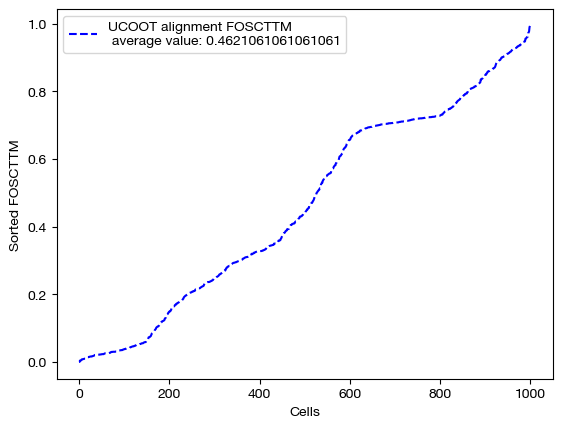

In [19]:
fracs = calc_domainAveraged_FOSCTTM(adt, aligned_rna.numpy())
legend_label="UCOOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

In [20]:
joint_um=um.fit_transform(np.concatenate((adt, aligned_rna.numpy()), axis=0))

adt_um=joint_um[0:1000,]
rna_um=joint_um[1000:,]

plt.scatter(adt_um[:,0], adt_um[:,1], c="k", s=5, label="ADT")
plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

NameError: name 'um' is not defined

<Axes: >

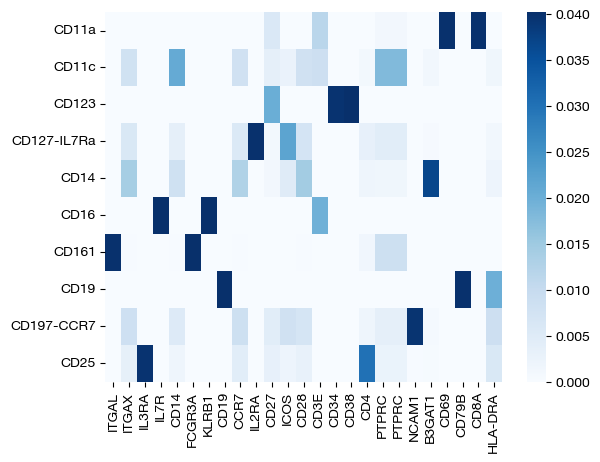

In [21]:
sns.heatmap(pd.DataFrame(pi_feat, index=adt_annotated.columns, columns=rna_full_annotated.columns), cmap='Blues')

Note that the row sums remain the same considering we set $\rho_x$ = infty, but the column sums vary significantly. Also, we can see that more mass condenses on the left side of the matrix, which is what we would expect!

```{tip}
The logic we have examined in this section can also be applied to sample unbalancing; see our final section in the UGW tutorial for a short experiment. In addition, sample unbalancing can be very useful in the case that there is disproportionate cell type representation in a separately assayed pair of datasets.
```

### Conclusion

Hopefully, this explanation of the parameters of UCOOT has helped develop some intuition for how to tune UCOOT for your specific needs. To get more information on UCOOT, visit the tutorial that dives into how to use prior knowledge to aid your alignment (D and alpha hyperparameters, as well as other initializations). Once you read that, you can move on to our AGW tutorial.

Citations:

Quang Huy Tran, Hicham Janati, Nicolas Courty, Rémi Flamary, Ievgen Redko, Pinar Demetci and Ritambhara Singh. Unbalanced CO-Optimal Transport. arXiv, stat.ML, 2023.